<a href="https://colab.research.google.com/github/godsesaurab/data-science-projects/blob/main/7.%20Anomaly%20Detection%20with%20Auto-Encoders/Anomaly_Detection_with_Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection with Auto-Encoders

## Table of Contents

1. Unsupervised Learning with Auto-Encoders
2. Preprocessing
3. Visualising clusters with t-SNE
4. Train/Validate/Test split
5. Normalising & Standardising
6. Training the auto-encoder
7. Reconstructions
8. Setting a threshold for classification
9. Latent Space
10. Conclusion

## 1. Unsupervised Learning with Auto-Encoders

Functioning of Auto Encoders - https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

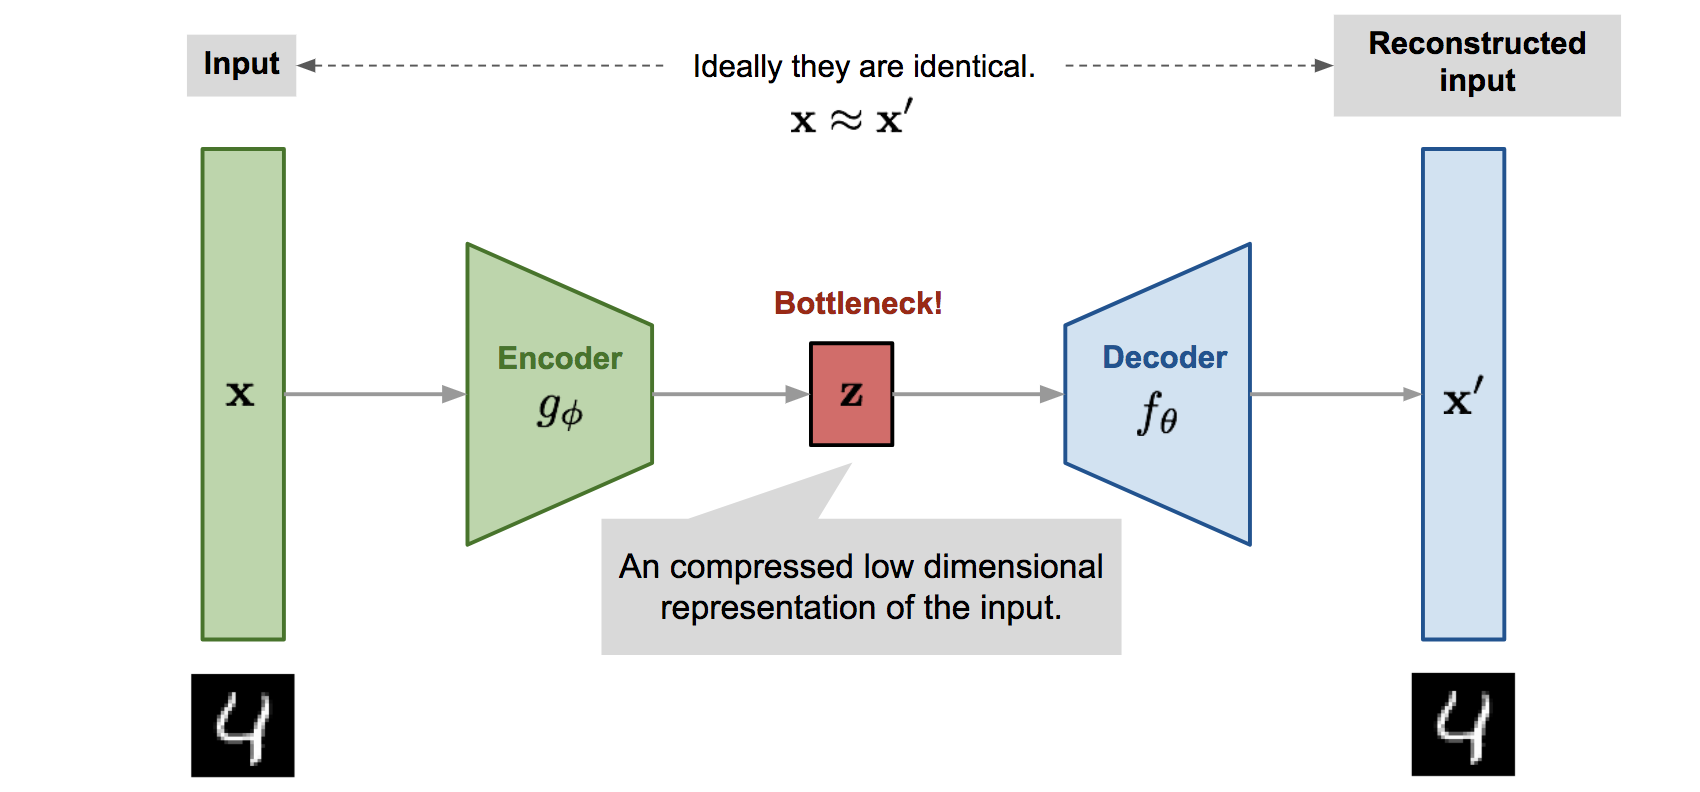

The idea is quite straightforward:

1. Due to the bottleneck architecture of the neural network, it is forced to learn a condensed representation from which to reproduce the original input.
2. We feed it only normal transactions, which it will learn to reproduce with high fidelity.
3. As a consequence, if a fraud transaction is sufficiently distinct from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent reconstruction loss will be high.
4. Anything above a specific loss (treshold) will be flagged as anomalous and thus labeled as fraud.

## 2. Preprocessing

Import Libraries & set Random Seed

In [2]:
# read & manipulate data
import pandas as pd
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn




In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [5]:
# load the dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [8]:
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.RANDOM_SEED = RANDOM_SEED

### Renaming columns

In [10]:
# converting the columns to lower case and renaming the Class column
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class':'label'},inplace=True)

# printing first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Calculated field: log10(amount)
Turn the amount feature into a normally distributed log equivalent

In [11]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [12]:
# keep the label field at the end
df = df[
    [col for col in df if col not in ['label','log10_amount']]
    +
    ['log10_amount','label']
]

### Visualising clusters with t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE)

From the sklearn documentation:

> t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: t-SNE is a dimensionality reduction technique used for visualisations of complex datasets. It maps clusters in high-dimensional data to a two- or three dimensional plane so we can get an idea of how easy it will be to discriminate between classes. it does this by trying to keep the distance between data points in lower dimesions proportional to the probability that these data points are neighbours in the higher dimensions.

more details : https://www.datacamp.com/community/tutorials/introduction-t-sne




### Undersampling the non-fraud

To keeo the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).

In [13]:
# manual parameter
RATIO_TO_FRAUD = 15

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
    )

In [14]:
# cocatenate with fraud transactions into a single data frame
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features, lables = visualisation_initial.drop('label', axis=1).values, \
visualisation_initial.label.values

In [15]:
print(f"""
The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to frauds.
""")


The non-fraud dataset has been undersampled from 284,315 to 7,380.
This represents a ratio of 15:1 to frauds.

